<a href="https://colab.research.google.com/github/mabuice/AMATH_Visual_Coding/blob/main/Homework_Decoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="background: #F0FAFF; border-radius: 3px; padding: 10px;">
<h3> This notebook will explore decoding using the Allen Brain Observatory data </h3>
    
In this notebook, we'll look at decoding using different models, different definitions of the design matrix, and different neural populations.


In [3]:
# @title Run to initialize Allen Brain Observatory on Colab {display-mode: "form" }
# run only once per runtime/session, and only if running in colab
# the runtime will need to restart after
%%capture
!apt install s3fs
!pip install allensdk
!mkdir -p /data/allen-brain-observatory/
!s3fs allen-brain-observatory /data/allen-brain-observatory/ -o public_bucket=1

### Standard imports

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
import matplotlib.colors as mcolors
colors = list(mcolors.TABLEAU_COLORS.values())

### Allen Brain Observatory set up

In [5]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

manifest_file = '../data/allen-brain-observatory/visual-coding-2p/manifest.json'
boc = BrainObservatoryCache(manifest_file=manifest_file)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
The command below returns a list of dictionaries containing information about the experiment sessions.  As we saw in the main notebook, you can use optional arguments to specify subsets of experiment sessions.  (Hint:  use the help function to see other ways of choosing sessions.)
</div>

In [26]:
exps = boc.get_ophys_experiments()
# help(boc.get_ophys_experiments)
st =  boc.get_all_session_types()



In [12]:
pd.DataFrame(exps)


/usr/local/lib/python3.11/dist-packages/google/colab/_interactive_table_hint_button.py:178: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  df_html=dataframe._repr_html_(),  # pylint: disable=protected-access


,id,imaging_depth,targeted_structure,cre_line,reporter_line,acquisition_age_days,experiment_container_id,session_type,donor_name,specimen_name,fail_eye_tracking
0,566752133,175,VISl,Emx1-IRES-Cre,Ai93(TITL-GCaMP6f),116,564425775,three_session_C2,283147,Emx1-IRES-Cre;Camk2a-tTA;Ai93-283147,True
1,653123586,275,VISl,Rorb-IRES2-Cre,Ai93(TITL-GCaMP6f),111,653123584,three_session_C2,352471,Rorb-IRES2-Cre;Camk2a-tTA;Ai93-352471,True
2,577225417,275,VISl,Vip-IRES-Cre,Ai148(TIT2L-GC6f-ICL-tTA2),105,575772104,three_session_C2,296710,Vip-IRES-Cre;Ai148-296710,False
3,556353209,375,VISam,Rbp4-Cre_KL100,Ai93(TITL-GCaMP6f),101,555327033,three_session_A,271750,Rbp4-Cre;Camk2a-tTA;Ai93-271750,True
4,510390912,275,VISal,Rorb-IRES2-Cre,Ai93(TITL-GCaMP6f),80,511500480,three_session_A,232623,Rorb-IRES2-Cre;Camk2a-tTA;Ai93-232623,False
...,...,...,...,...,...,...,...,...,...,...,...
1363,577820172,275,VISam,Rorb-IRES2-Cre,Ai93(TITL-GCaMP6f),110,576411244,three_session_B,295995,Rorb-IRES2-Cre;Camk2a-tTA;Ai93-295995,False
1364,648389302,275,VISp,Slc17a7-IRES2-Cre,Ai93(TITL-GCaMP6f),108,647155120,three_session_B,347751,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93-347751,False
1365,510517609,375,VISpm,Rbp4-Cre_KL100,Ai93(TITL-GCaMP6f),75,511511006,three_session_B,233442,Rbp4-Cre;Camk2a-tTA;Ai93-233442,False
1366,547560448,350,VISal,Nr5a1-Cre,Ai93(TITL-GCaMP6f),107,546328009,three_session_C2,261969,Nr5a1-Cre;Camk2a-tTA;Ai93-261969,False


In [27]:
pd.DataFrame(st)

/usr/local/lib/python3.11/dist-packages/google/colab/_interactive_table_hint_button.py:178: FutureWarning: RangeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  df_html=dataframe._repr_html_(),  # pylint: disable=protected-access


,0
0,three_session_A
1,three_session_B
2,three_session_C
3,three_session_C2


The following function will grab the data_set object for a given session_id.  The last two lines will extract the dF/F traces and the stimulus table for a given stimulus type.  

Some other stimulus types are `natural_scenes` and `static_gratings`.

In [13]:
session_id = exps[3]['id']
data_set = boc.get_ophys_experiment_data(session_id)

timestamps, dff = data_set.get_dff_traces()
stim_table = data_set.get_stimulus_table('drifting_gratings')

**Exercise 1:** Use a different decoder and repeat the same analysis.  Good decoders to try are Logistic Regression, Support Vector Machine, K-Means.

Logistic Regression:
https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html

Support Vector Machine:
https://scikit-learn.org/1.6/modules/generated/sklearn.svm.SVC.html

(Note:  look through the documentation to see what parameters govern these decoders.  How should you set them?  What effect do they have on the performance of your classifier?)


In [14]:
num_trials = stim_table.shape[0]
num_neurons = dff.shape[0]

activity = np.zeros([num_trials, num_neurons])
stim = []   # why are we using a list?

for i, row in stim_table.iterrows():
  activity[i] = dff[:,int(row.start):int(row.end)].mean(axis=1) #  compute the mean for *each* neuron
  if np.isfinite(row.orientation):
    stim.append(str(row.orientation))
  else:
    stim.append('blank')

stim = np.array(stim)

In [15]:
orientations = np.sort(stim_table.orientation.unique())
orientation_labels = [str(ori) for ori in orientations[:-1]] + ['blank']
num_orientations = len(orientations)
tuning_curves = np.zeros([num_neurons, num_orientations-1])

for i, ori in enumerate(orientations[:-1]):  # leave out nans
  mask = stim==str(ori)
  tuning_curves[:,i] = activity[mask,:].mean(axis=0)

tf_stim = []

for i, row in stim_table.iterrows():
  if np.isfinite(row.temporal_frequency):
    tf_stim.append(str(row.temporal_frequency))
  else:
    tf_stim.append('blank')

tf_stim = np.array(tf_stim)

temporal_frequencies = np.sort(stim_table.temporal_frequency.unique())
tf_labels = [str(tf) for tf in temporal_frequencies[:-1]] + ['blank']
num_tfs = len(temporal_frequencies)
tf_tuning_curves = np.zeros([num_neurons, num_tfs-1])

for i, tf in enumerate(temporal_frequencies[:-1]):
  mask = tf_stim==str(tf)
  tf_tuning_curves[:,i] = activity[mask,:].mean(axis=0)

In [16]:
np.where(tuning_curves.max(axis=1)>0.25)

cell_index1 = 15
cell_index2 = 16

two_neuron_activity = activity[:,[cell_index1,cell_index2]]

Text(0, 0.5, 'cell index 16')

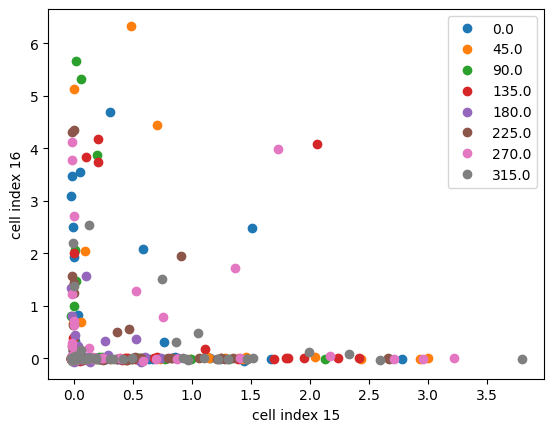

In [17]:
for i, ori in enumerate(orientations[:-1]):
  mask = stim==str(ori)
  plt.plot(two_neuron_activity[mask,0], two_neuron_activity[mask,1],'o',color=colors[i], label=ori)
  plt.legend()
plt.xlabel('cell index '+str(cell_index1))
plt.ylabel('cell index '+str(cell_index2))

In [18]:
test_index = int(0.75*num_trials)

two_neuron_activity_test = two_neuron_activity[test_index:]
two_neuron_activity_train = two_neuron_activity[:test_index]

stim_test = stim[test_index:]
stim_train = stim[:test_index]

(two_neuron_activity_test.shape, stim_test.shape), (two_neuron_activity_train.shape, stim_train.shape)

(((157, 2), (157,)), ((471, 2), (471,)))

In [19]:
from sklearn import svm

clf = svm.LinearSVC()
clf.fit(two_neuron_activity_train, stim_train)

stim_train_hat2 = clf.predict(two_neuron_activity_train)
stim_test_hat2 = clf.predict(two_neuron_activity_test)

print("Percentage correct on training set:  ", np.mean(stim_train_hat2 == stim_train))

print("Percentage correct on testing set:  ", np.mean(stim_test_hat2 == stim_test))



Percentage correct on training set:   0.14012738853503184
Percentage correct on testing set:   0.10828025477707007


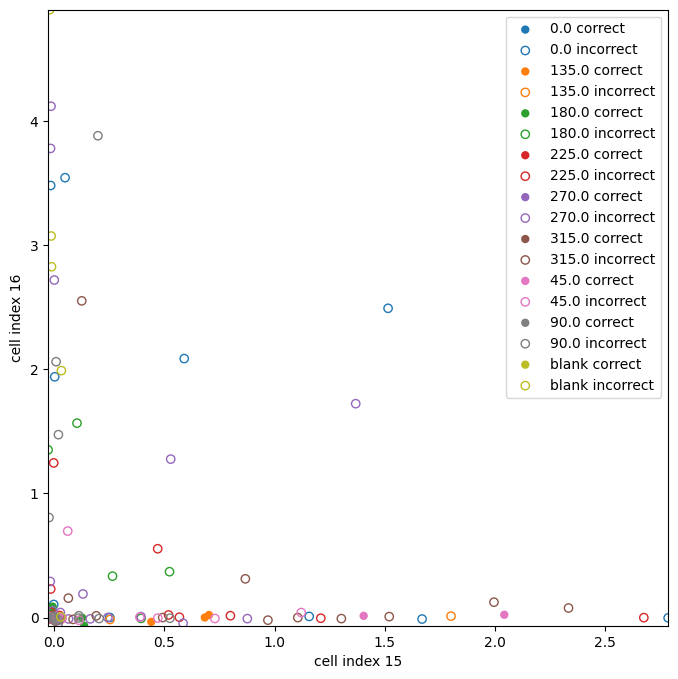

<Axes: xlabel='cell index 15', ylabel='cell index 16'>

In [20]:
def plot_test_performance(X, y, y_hat, xlabel=None, ylabel = None, names = None, ax = None):

    classes = np.unique(y)
    num_classes = len(classes)

    if ax is None:
        ax = plt.figure(figsize=(8,8)).gca()

    for ii,cl in enumerate(classes):
        if names is not None: # If 'names' was passed, use this for label
            this_label = names[ii]
        else:
            this_label = f'{cl}' # If 'names' was passed, otherwise use class number

        # Determine which points were correct (or not)
        is_class = y == cl
        is_correct = y == y_hat

        # Plot correctness with labels
        ax.scatter(X[is_class & is_correct,0],X[is_class & is_correct,1],c=colors[ii],edgecolor='none',label = this_label + ' correct')
        ax.scatter(X[is_class & ~is_correct,0],X[is_class & ~is_correct,1],c='none',edgecolor=colors[ii],label =this_label + ' incorrect')

    ax.set_xlim(X[:,0].min(),X[:,0].max())
    ax.set_ylim(X[:,1].min(),X[:,1].max())
    ax.set_xlabel(xlabel)# Optionally label axes
    ax.set_ylabel(ylabel)# Optionally label axes
    ax.legend()
    plt.show()
    return ax
plot_test_performance(two_neuron_activity_test, stim_test, stim_test_hat2, xlabel='cell index '+ str(cell_index1), ylabel='cell index '+ str(cell_index2))

In [21]:
tf_stim_test = tf_stim[test_index:]
tf_stim_train = tf_stim[:test_index]

(two_neuron_activity_test.shape, tf_stim_test.shape), (two_neuron_activity_train.shape, tf_stim_train.shape)

tf_classifier = svm.LinearSVC()
tf_classifier.fit(two_neuron_activity_train, tf_stim_train)

tf_stim_train_hat2 = tf_classifier.predict(two_neuron_activity_train)
tf_stim_test_hat2 = tf_classifier.predict(two_neuron_activity_test)

print("Percentage correct on training set:  ", np.mean(tf_stim_train_hat2 == tf_stim_train))
print("Percentage correct on testing set:  ", np.mean(tf_stim_test_hat2 == tf_stim_test))



Percentage correct on training set:   0.2208067940552017
Percentage correct on testing set:   0.17197452229299362


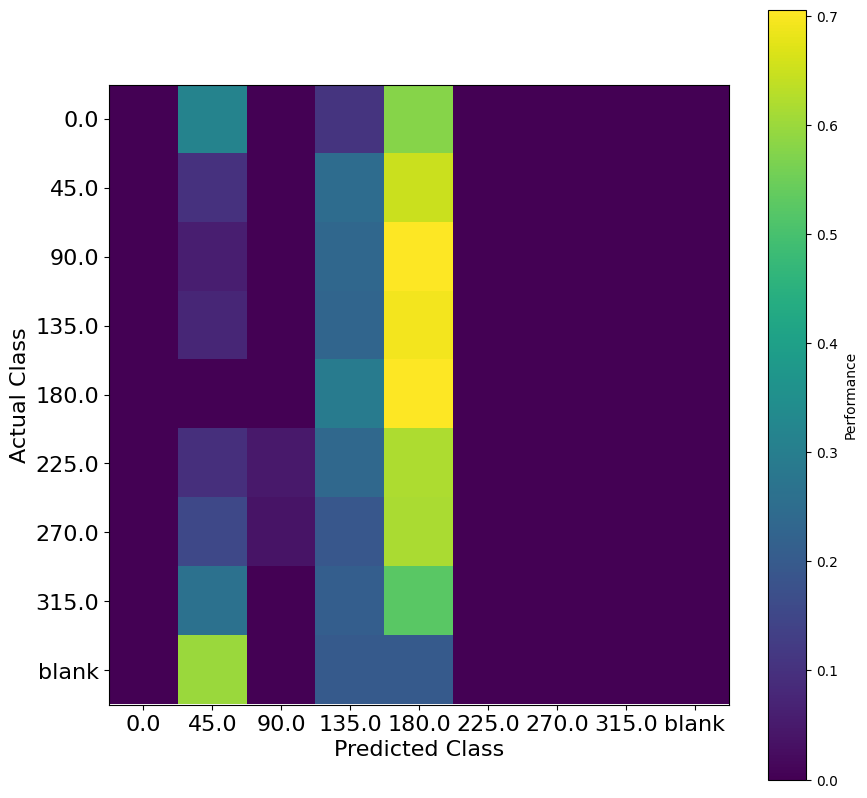

In [22]:
from sklearn.metrics import confusion_matrix

C = confusion_matrix(stim_test, stim_test_hat2, normalize = 'true', labels=orientation_labels)
# Note that normalization is needed when all classes are not of the same size
# The default is to plot based on counts

num_classes = len(orientation_labels)

plt.figure(figsize=(10, 10))
ax = plt.subplot(111)
cax = ax.imshow(C,interpolation='none', vmin=0, vmax=C.max())

ax.set_xlabel('Predicted Class', fontsize=16)
ax.set_ylabel('Actual Class', fontsize=16)

ax.set_xticks(range(num_classes))
ax.set_xticklabels(orientation_labels, fontsize=16)

ax.set_yticks(range(num_classes))
ax.set_yticklabels(orientation_labels, fontsize=16)

cbar = plt.colorbar(cax)
cbar.set_label('Performance')

plt.show()

Percentage correct on training set:   0.2484076433121019
Percentage correct on testing set:   0.1464968152866242


Text(0.5, 0, 'number of neurons')

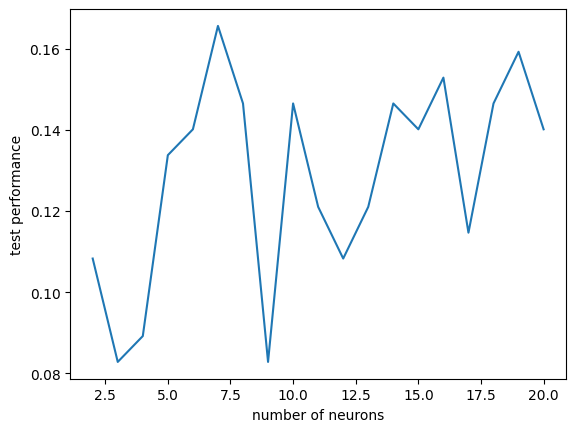

In [23]:
test_index = int(0.75*num_trials)

activity_test = activity[test_index:]
activity_train = activity[:test_index]

stim_test = stim[test_index:]
stim_train = stim[:test_index]

(activity_test.shape, stim_test.shape), (activity_train.shape, stim_train.shape)

all_neuron_classifier = svm.LinearSVC()
all_neuron_classifier.fit(activity_train, stim_train)

stim_train_hat = all_neuron_classifier.predict(activity_train)
stim_test_hat = all_neuron_classifier.predict(activity_test)

print("Percentage correct on training set:  ", np.mean(stim_train_hat == stim_train))

print("Percentage correct on testing set:  ", np.mean(stim_test_hat == stim_test))

performance = np.zeros(num_neurons-2)

test_index = int(0.75*num_trials)
stim_test_n = stim[test_index:]
stim_train_n = stim[:test_index]

for n in range(2, num_neurons):
  neuron_indices = np.random.permutation(np.arange(num_neurons))[:n] # choose n random neurons

  activity_test_n = activity[test_index:, neuron_indices]
  activity_train_n = activity[:test_index, neuron_indices]

  n_classifier = svm.LinearSVC()
  n_classifier.fit(activity_train_n, stim_train_n)

  stim_test_hat_n = n_classifier.predict(activity_test_n)

  performance[n-2] = np.mean(stim_test_hat_n == stim_test_n)

plt.plot(np.arange(2,num_neurons), performance)
plt.ylabel('test performance')
plt.xlabel('number of neurons')

**Exercise 2:** Use a different stimulus type.  In addition to ‘drifting_gratings’, there are also ‘natural_scenes’ and ‘static_gratings’.  Find a session with these stimuli and try decoding the stimulus condition.

(Hint:  use the function given above to get a list of experiments and convert it to a dataframe).*italicized text*
</div>

In [23]:
session_id = exps[3]['id']
data_set = boc.get_ophys_experiment_data(session_id)

timestamps, dff = data_set.get_dff_traces()
stim_table = data_set.get_stimulus_table('drifting_gratings')

num_trials = stim_table.shape[0]
num_neurons = dff.shape[0]

activity = np.zeros([num_trials, num_neurons])
stim = []   # why are we using a list?

for i, row in stim_table.iterrows():
  activity[i] = dff[:,int(row.start):int(row.end)].mean(axis=1) #  compute the mean for *each* neuron
  if np.isfinite(row.orientation):
    stim.append(str(row.orientation))
  else:
    stim.append('blank')

stim = np.array(stim)



**Exercise 3:** Compare the decoding performance between sessions from different areas.  Does decoding of drifting gratings work better in VISp compared to other areas?  
</div>

**Exercise 4:**  Compare the decoding performance between sessions from different areas of similar depth.</div>

**Exercise 5:** Compare the decoding performance between sessions from different Cre lines of VISp.


**Exercise 6**:  Compute the design matrix using a different time window or different time offset relative to the stimulus.  Redo the decoding.  What happens as you move the window from before to after the stimulus presentation time?